In [1]:
import numpy as np
import matplotlib.pyplot as plt

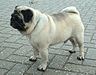

In [3]:
from PIL import Image

image = Image.open("media/pug.jpg")
image

In [3]:
x0 = np.array(image).astype(np.float32) / 255.0
x0.shape

(75, 96, 3)

In [4]:
class Diffusion:
    def __init__(self, diff_steps = 200):
        self.diff_steps = diff_steps
        self.betas = np.linspace(1e-4, 0.02, diff_steps)
        self.alphas = 1 - self.betas
        self.alpha_bars = np.cumprod(self.alphas)
        
    def forward(self, x_0, t):
        epsilon = np.random.randn(*x_0.shape)
        alpha_bar = self.alpha_bars[t]
        x_t = np.sqrt(alpha_bar) * x_0 + np.sqrt(1 - alpha_bar) * epsilon
        return x_t, epsilon



In [5]:
model = Diffusion()

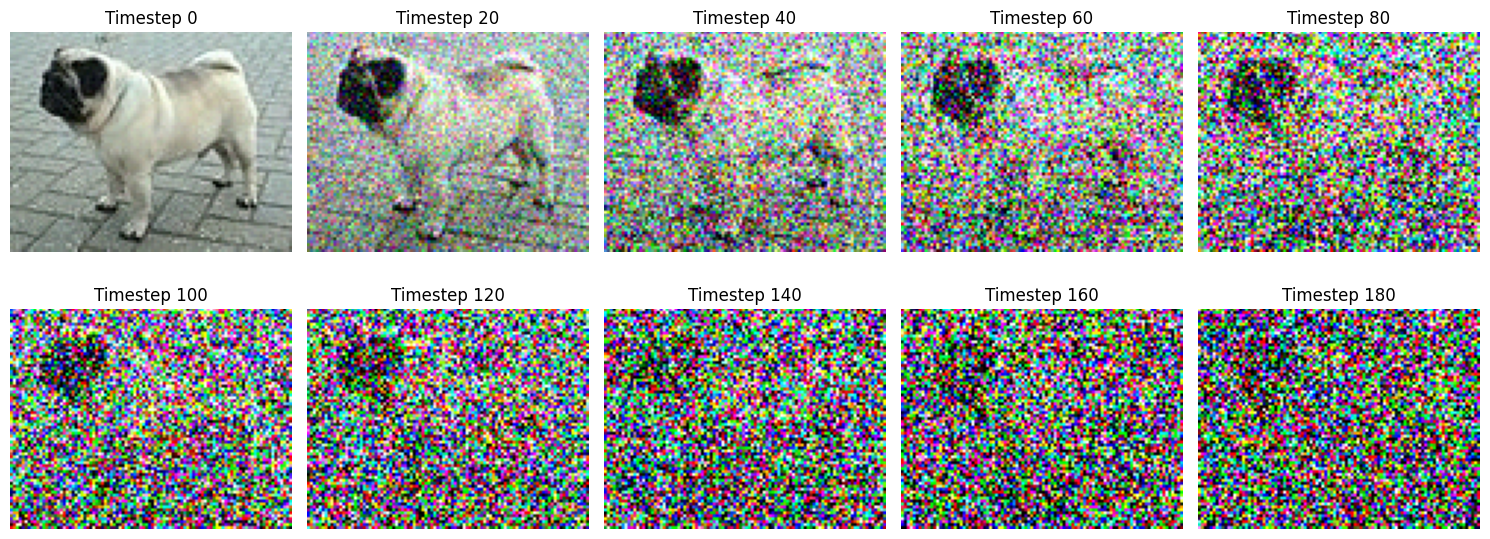

In [6]:
timesteps = [i for i in range(0, model.diff_steps, model.diff_steps // 10)]
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, t in enumerate(timesteps):
    row = i // 5
    col = i % 5
    xt, epsilon = model.forward(x0, t)
    axes[row, col].imshow(np.clip(xt, 0, 1))
    axes[row, col].set_title(f"Timestep {t}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# For sake of simplicity, we'll use mlp rather than UNet for reversing the diffusion process

# Taken from CNN implementation
class Dense:
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size) * 0.1
        self.biases = np.random.randn(output_size) * 0.1

    def forward(self, x):
        self.input = x
        return self.weights @ x + self.biases

    def backward(self, grad_output):
        self.grad_weights = np.outer(grad_output, self.input)
        self.grad_biases = grad_output

        return self.weights.T @ grad_output

    def update(self, lr):
        self.weights -= lr * self.grad_weights
        self.biases -= lr * self.grad_biases

class Relu:
    def forward(self, x):
        self.input = x
        return np.maximum(0, x)

    def backward(self, grad_output):
        grad_input = grad_output.copy()
        grad_input[self.input <= 0] = 0
        return grad_input

class Model:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad_output):
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)

    def predict(self, x):
        logits = self.forward(x)
        return np.argmax(logits)

    def update(self, lr):
        for layer in self.layers:
            if hasattr(layer, "update"):
                layer.update(lr)

class MSE:
    def forward(self, pred, target):
        self.pred = pred
        self.target = target
        return np.mean((pred - target) ** 2)

    def backward(self):
        return 2 * (self.pred - self.target) / self.pred.size

In [8]:
model = Model([
    Dense(32 + 32 + 32, 64), # 32,32 -> x and y embeddings, another for our t embeddings
    Relu(),
    Dense(64, 128),
    Relu(),
    Dense(128, 2)
    
])

diffusion_model = Diffusion()

In [9]:
def timestep_embedding(t, dim=32):
    half_dim = dim // 2
    emb = np.log(10000) / (half_dim - 1)
    emb = np.exp(np.arange(half_dim) * -emb)
    emb = t * emb
    return np.concatenate([np.sin(emb), np.cos(emb)]) * 0.1

def input_embedding(x, dim=32, scale=25.0):
    half_dim = dim // 2
    emb = np.log(10000) / (half_dim - 1)
    emb = np.exp(np.arange(half_dim) * -emb)
    emb = x * emb * scale
    return np.concatenate([np.sin(emb), np.cos(emb)]) * 0.1
    

def train(model, diffusion_model, trainX, epoch = 500):
    loss_fn = MSE()
    lr = 1e-3

    for i in range(epoch):
        loss = 0
        for x_0 in trainX:
            T = diffusion_model.diff_steps
            t = np.random.randint(0, T - 1)
            x_t, epsilon = diffusion_model.forward(x_0, t)
            
            t_emb = timestep_embedding(t / T)
            x_emb = input_embedding(x_t[0], dim=32)
            y_emb = input_embedding(x_t[1], dim=32)
            
            x_in = np.concatenate([x_emb, y_emb, t_emb])
    
            epsilon_pred = model.forward(x_in)
            loss += loss_fn.forward(epsilon_pred, epsilon.flatten())
    
            model.backward(loss_fn.backward())
            model.update(lr)
        if i % 10 == 0:
            print(f"Epoch {i}: loss is {loss / len(trainX)}")

In [10]:
def heart_dataset(n=8000):
    rng = np.random.default_rng(42)
    theta = 2 * np.pi * rng.uniform(0, 1, n)
    x = 16 * np.sin(theta)**3
    y = 13 * np.cos(theta) - 5 * np.cos(2*theta) - 2 * np.cos(3*theta) - np.cos(4*theta)
    X = np.stack((x, y), axis=1)
    X /= 5
    return X.astype(np.float32)
X_train = heart_dataset()

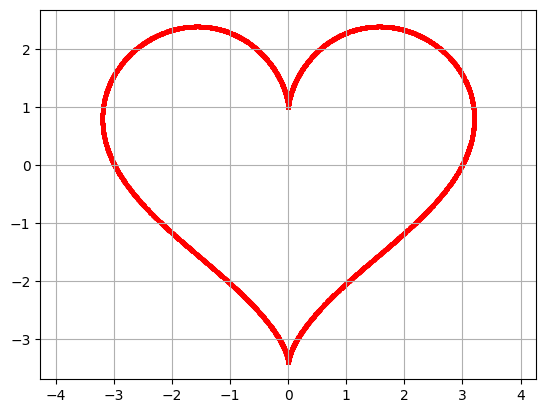

In [11]:
plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], s=5, color="red")
plt.axis("equal")
plt.grid(True)
plt.show()

In [12]:
train(model, diffusion_model, X_train)

Epoch 0: loss is 1.0011250789497679
Epoch 10: loss is 0.8501622682497064
Epoch 20: loss is 0.8128828970561072
Epoch 30: loss is 0.7544557652783214
Epoch 40: loss is 0.6990527076675143
Epoch 50: loss is 0.6659329659357948
Epoch 60: loss is 0.6414145868285064
Epoch 70: loss is 0.6180552959573894
Epoch 80: loss is 0.6155835912614899
Epoch 90: loss is 0.5946264191862396
Epoch 100: loss is 0.5928961301744621
Epoch 110: loss is 0.593970143472241
Epoch 120: loss is 0.5879401634209077
Epoch 130: loss is 0.5737801739416764
Epoch 140: loss is 0.586193655638226
Epoch 150: loss is 0.566393166673402
Epoch 160: loss is 0.5813706762972854
Epoch 170: loss is 0.5807168377612874
Epoch 180: loss is 0.5780062372818531
Epoch 190: loss is 0.5734058250670878
Epoch 200: loss is 0.5560244164043519
Epoch 210: loss is 0.5761887524996554
Epoch 220: loss is 0.5515948690896796
Epoch 230: loss is 0.5753815374301257
Epoch 240: loss is 0.5722704817034105
Epoch 250: loss is 0.5505362269390326
Epoch 260: loss is 0.56558

In [22]:
def iterative_denoise(model, diffusion_model, x, start_t, embedding_dim=128):
    for t in reversed(range(start_t + 1)):
        t_emb = timestep_embedding(t / diffusion_model.diff_steps)
        x_emb = input_embedding(x[0], dim=32)
        y_emb = input_embedding(x[1], dim=32)

        model_input = np.concatenate([x_emb, y_emb, t_emb])
        
        epsilon_pred = model.forward(model_input)
        
        alpha = diffusion_model.alphas[t]
        alpha_bar = diffusion_model.alpha_bars[t]
        beta = diffusion_model.betas[t]
        
        mean = (1 / np.sqrt(alpha)) * (x - (beta / np.sqrt(1 - alpha_bar)) * epsilon_pred)
        
        noise = np.random.randn(*x.shape)
        x = mean + np.sqrt(beta) * noise
    
    return x


In [26]:
T = diffusion_model.diff_steps
timesteps = [i for i in range(0, T, 50)]

corrupted = []
predicted = []

for x_0 in X_train:
    sample_corrupted = []
    sample_predicted = []
    for t in timesteps:
        c = diffusion_model.forward(x_0, t)[0]
        p = iterative_denoise(model, diffusion_model, c, t)
        
        sample_corrupted.append(c)
        sample_predicted.append(p)
    corrupted.append(sample_corrupted)
    predicted.append(sample_predicted)

corrupted = np.array(corrupted)
predicted = np.array(predicted)

Text(0, 0.25, 'Predicted')

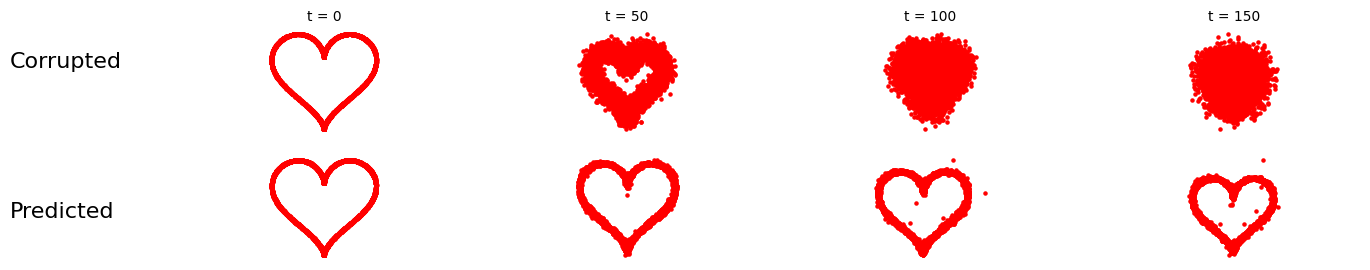

In [37]:
fig, axes = plt.subplots(2, len(timesteps), figsize=(15, 3))

for idx, time in enumerate(timesteps):
    axes[0, idx].scatter(corrupted[:, idx, 0], corrupted[:, idx, 1], s=5, color="red")
    axes[0, idx].axis("equal")
    axes[0, idx].grid(True)
    axes[0, idx].axis("off")
    axes[0, idx].set_title(f"t = {time}", fontsize=10)

    axes[1, idx].scatter(predicted[:, idx, 0], predicted[:, idx, 1], s=5, color="red")
    axes[1, idx].axis("equal")
    axes[1, idx].grid(True)
    axes[1, idx].axis("off")
    
fig.text(0, 0.75, "Corrupted", fontsize=16)
fig.text(0, 0.25, "Predicted", fontsize=16)